# Evaluating cloud dilation options for Landsat Fmask <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment
* **Products used:** 
[ga_ls5t_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls5t_ard_3),
[ga_ls7e_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls7e_ard_3),
[ga_ls8c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls8c_ard_3),
[ga_ls9c_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls9c_ard_3)



## Getting started

### Load packages
Import Python packages used for the analysis.


In [4]:
import datacube
from datacube.utils.masking import make_mask
from odc.algo import mask_cleanup

import sys

sys.path.insert(1, "../Tools/")
from dea_tools.dask import create_local_dask_cluster

# Launch Dask cluster
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/aaron.ohehir@ga.gov.au/proxy/8787/status,
Dashboard: /user/aaron.ohehir@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 2,Total memory: 12.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37427,Workers: 1
Dashboard: /user/aaron.ohehir@ga.gov.au/proxy/8787/status,Total threads: 2
Started: Just now,Total memory: 12.21 GiB
Comm: tcp://127.0.0.1:43029,Total threads: 2
Dashboard: /user/aaron.ohehir@ga.gov.au/proxy/35035/status,Memory: 12.21 GiB
Nanny: tcp://127.0.0.1:45429,


### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [13]:
dc = datacube.Datacube(app="Testing_cloud_dilation")

Assumptions

In [14]:
# cloud buffering range?
start_buffering = 0
end_buffering = 20

# bands?
bands = ["nbart_blue", "nbart_red", "oa_fmask"]

# time range?
start_time = "2015"
end_time = "2016"

# products?
products = ["ga_ls8c_ard_3", "ga_ls7e_ard_3", "ga_ls9c_ard_3"]
maturity = "final"



## Load data


Task exception was never retrieved
future: <Task finished name='Task-107431' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/env/lib/python3.8/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-107427' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/env/lib/python3.8/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-107426' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call l

KeyboardInterrupt: 

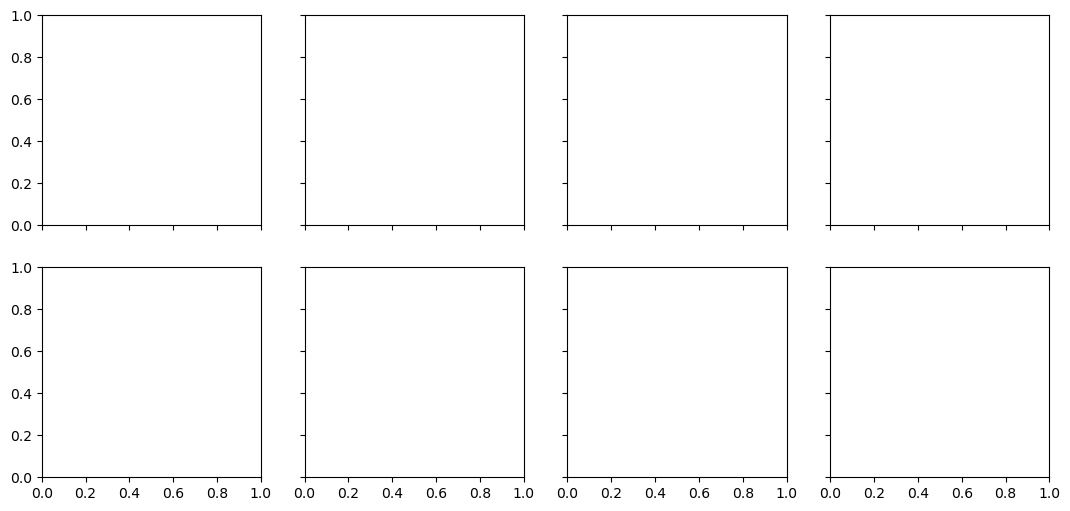

In [15]:
# Select spatiotemporal query (can be replaced with scene path/row)
query_params = dict(x=(140, 140.1), y=(-30, -30.1), time=(start_time, end_time))

# Set load params (measurements to load, Dask chunking, resampling etc)
load_params = dict(measurements=bands, dask_chunks={})

# Lazily load data
ds = dc.load(product=products, **query_params, **load_params)

# Plot
ds.nbart_blue.isel(time=slice(4, 12)).plot.imshow(col="time", robust=True, col_wrap=4)

## Fmask cloud and shadow mask
Based on content from: https://docs.dea.ga.gov.au/notebooks/How_to_guides/Masking_data.html

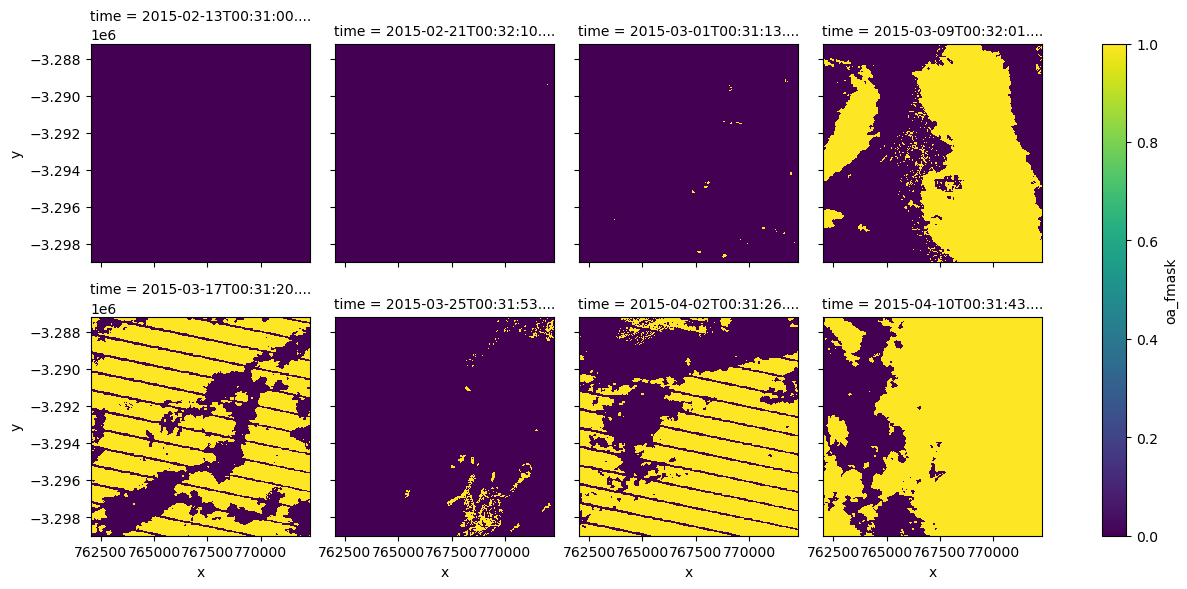

In [8]:
# Identify pixels that are either "cloud" or "cloud_shadow"
cloud_shadow_mask = make_mask(ds.oa_fmask, fmask="cloud") | make_mask(
    ds.oa_fmask, fmask="shadow"
)

# Plot
cloud_shadow_mask.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

### Applying dilation using `mask_cleanup`

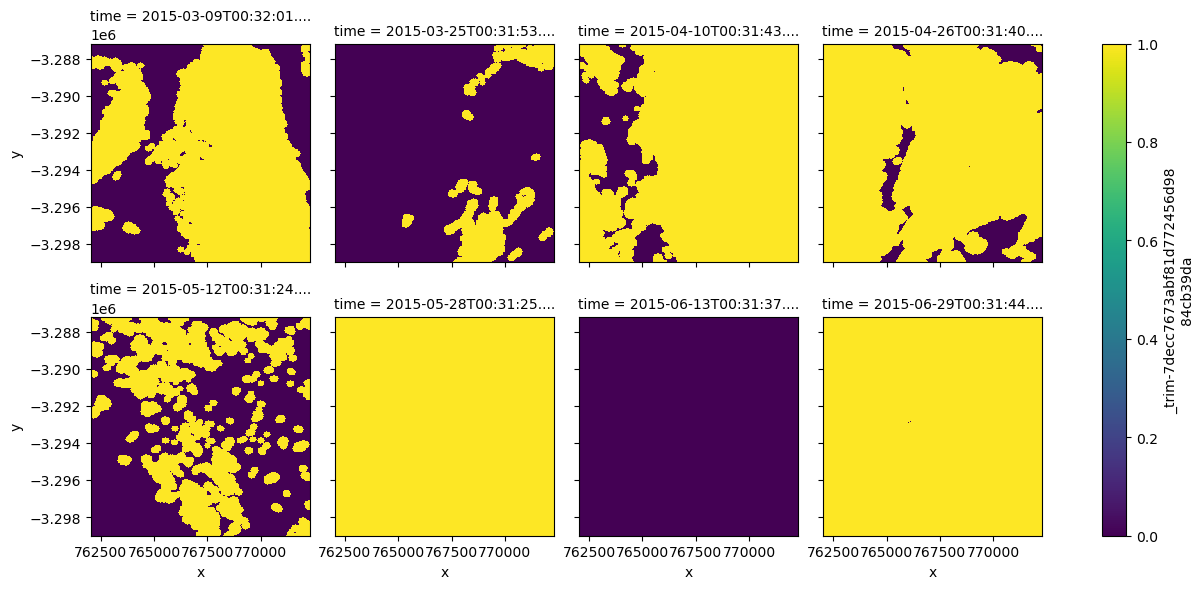

In [58]:
# Dilate all cloud and cloud shadow pixels by 5 pixels (uses a circular disk)
cloud_shadow_buffered = mask_cleanup(
    mask=cloud_shadow_mask, mask_filters=[("dilation", 5)]
)

# Plot
cloud_shadow_buffered.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

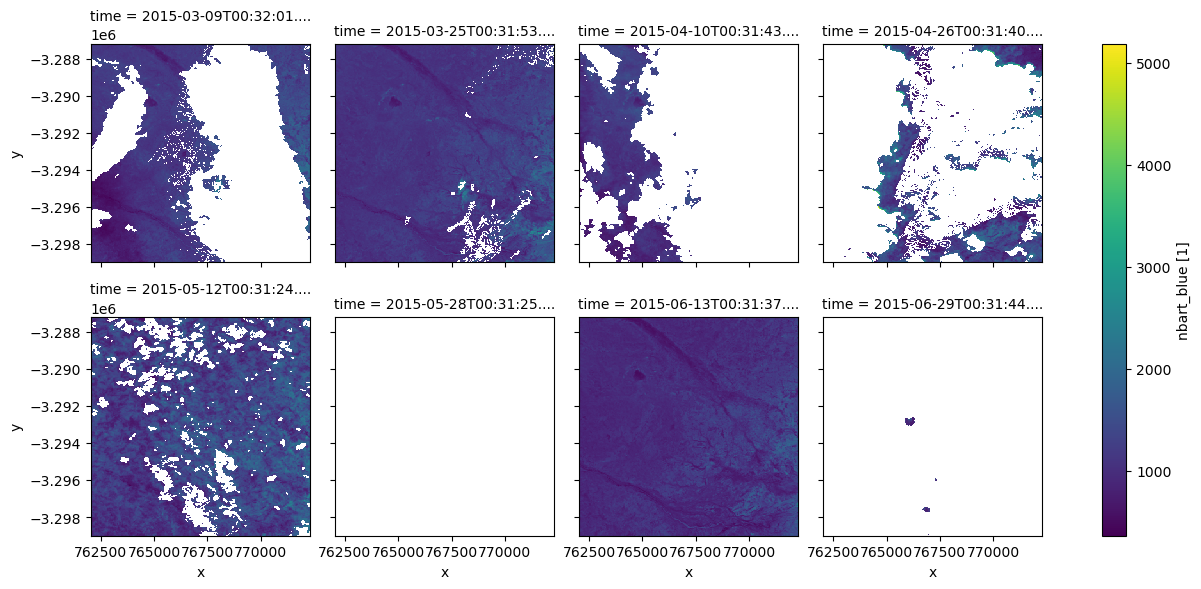

In [44]:
# apply mask with 0 dilation to blue band

# Apply the mask
clear = ds.where(~cloud_shadow_mask)

clear.nbart_blue.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

In [12]:
# apply mask with 5 dilation to blue band

# Apply the mask
clear_buffered = ds.where(~cloud_shadow_buffered)

clear_buffered.nbart_blue.isel(time=slice(4, 12)).plot(col="time", col_wrap=4)

NameError: name 'cloud_shadow_buffered' is not defined

In [11]:
clear_buffered.std("time").mean()

In [16]:
def get_std(buffer_size, ds): 
    # Dilate all cloud and cloud shadow pixels by n pixels (uses a circular disk)
    cloud_shadow_buffered = mask_cleanup(
        mask=cloud_shadow_mask, mask_filters=[("dilation", buffer_size)]
    )
    
    # Apply the mask
    clear_buffered = ds.where(~cloud_shadow_buffered)
    
    # load into memory
    clear_buffered.load()
    
    # calculate mean of std for time series
    return int(clear_buffered.nbart_blue.std("time").mean())

buffer_sd = {}
std = []

for buffer in range(start_buffering, end_buffering):
    std.append(get_std(buffer,ds))
    buffer_std[buffer] = get_std(buffer,ds)
    print('Buffer: ',str(buffer),'std: ',str(get_std(buffer,ds)))

Task exception was never retrieved
future: <Task finished name='Task-143178' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/env/lib/python3.8/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-143182' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/env/lib/python3.8/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-143198' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call l

KeyboardInterrupt: 

Task exception was never retrieved
future: <Task finished name='Task-143081' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/env/lib/python3.8/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-143084' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call last):
  File "/env/lib/python3.8/site-packages/distributed/client.py", line 2198, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-143086' coro=<Client._gather.<locals>.wait() done, defined at /env/lib/python3.8/site-packages/distributed/client.py:2189> exception=AllExit()>
Traceback (most recent call l

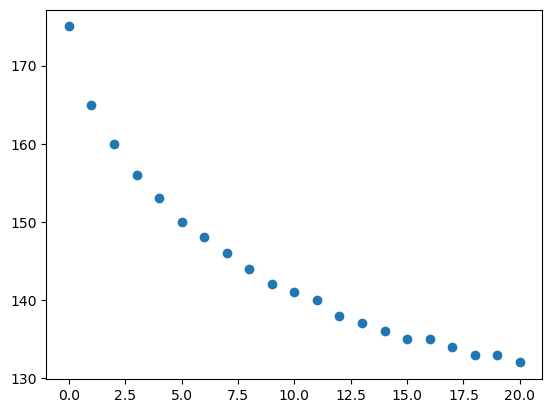

In [87]:
import matplotlib.pyplot as plt

plt.xlabel("buffer distance")
plt.ylabel("std")

plt.scatter(list(buffer_std.keys()), list(buffer_std.values()))
plt.show()


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** June 2023

**Compatible datacube version:** 

In [6]:
print(datacube.__version__)

1.8.13


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)